# Libraries

In [1]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random 
import argparse 
from tqdm import tqdm
from math import floor
import seaborn as sns
import yfinance as yf
from bandit_library import *

# Defining Inputs

In [39]:
##INTERVAL AND TRADING PERIOD##

interval = '1d'
tau = 365
m = 50

trade_start_time = datetime.datetime(2023,5,15,17,30)

if interval == '1d':
    hist_start_time = trade_start_time - datetime.timedelta(days=tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=m)
if interval == '1wk':
    hist_start_time = trade_start_time - datetime.timedelta(days=7*tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=7*m)
    
hist_end_time = trade_end_time

##INTERVAL AND TRADING PERIOD##

In [40]:
##STOCKS##

tickers = ['AC.PA','ALO.PA','AI.PA','ATO.PA','CAP.PA','ORA.PA','RI.PA','TTE.PA',
           'PINR.PA','SW.PA','SU.PA','BN.PA','PAASI.PA','PAEEM.PA','ML.PA','SK.PA']
n_assets = len(tickers)

##STOCKS##

In [41]:
data = Data(tickers)
hist_returns = data.get_data(hist_start_time,hist_end_time,interval)

Asset : ['AC.PA', 'ALO.PA', 'AI.PA', 'ATO.PA', 'CAP.PA', 'ORA.PA', 'RI.PA', 'TTE.PA', 'PINR.PA', 'SW.PA', 'SU.PA', 'BN.PA', 'PAASI.PA', 'PAEEM.PA', 'ML.PA', 'SK.PA']
[*********************100%***********************]  16 of 16 completed
start date   : 2022-05-15 17:30:00
start date   : 2023-07-04 17:30:00
time interval: 415 days, 0:00:00


# Brief Co-Dependence Analysis

Text(0.5, 1.0, 'Covariance Matrix')

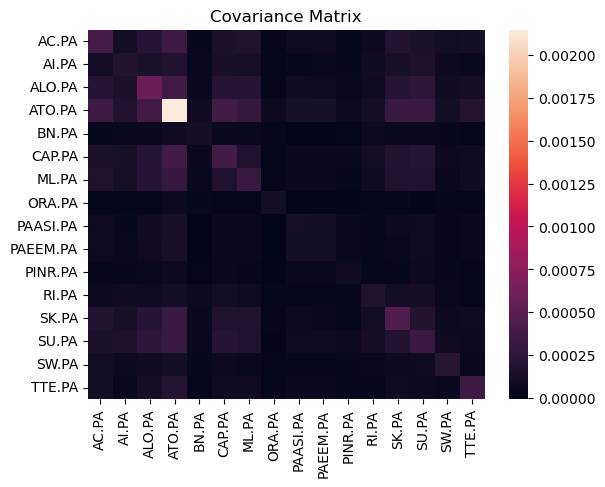

In [42]:
sns.heatmap(hist_returns.cov())
plt.title('Covariance Matrix')

Text(0.5, 1.0, 'Spearman Correlation')

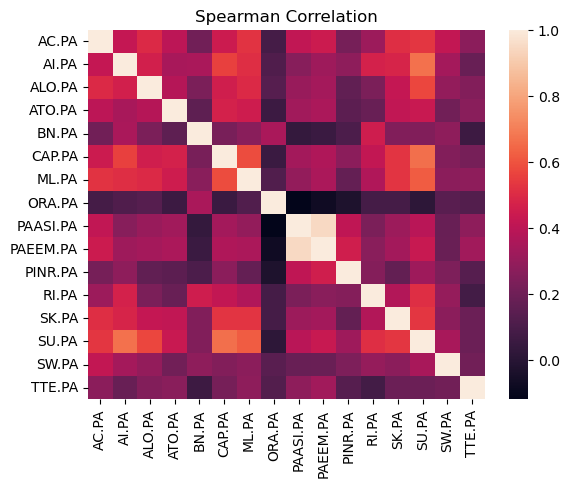

In [43]:
sns.heatmap(hist_returns.corr(method='spearman'))
plt.title('Spearman Correlation')

Let us compute the covariance matrix of our returns :

In [44]:
cov_matrix = get_cov(hist_returns)

This matrix is $\Sigma_k$ but we will need to eigen-decompose it .

We now estimate the average return $\mathbb{E}[\textbf{R}_k] \in \mathbb{R}_n $

 - $\tau$ represents the size of the training data 
 - Example : if we study an interval of 300 days, $\tau$ = 300
 - Our 'training' returns are in the interval $[k-\tau, k-1]$, hence the length is $k-1 - (k-\tau) + 1 = \tau$

NB : 
- hist_start_time = trading_start_time - $\tau$
- To ensure that the average return and the covariance matrix of assets returns $\Sigma_k$ are estimated by $(\textbf{R}_{k-\tau},..,\textbf{R}_{k-1})$

In [45]:
k=1

In [46]:
E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)

The next step is to decomposse of the covariance matrix :

In [47]:
Lambda, H = eigen_decomposition(Sigma)
Lambdas = np.diag(Lambda)

- Lambda corresponds to $\Lambda_k$
- Lambdas is a numpy array containing all the eigenvalues (the diagonal of $\Lambda_k$)
- H corresponds to $\mathcal{H}_k$

Now we compute the renormalized similarity matrices and eigenvalues :

In [48]:
Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
Lambdas_norm = np.diag(Lambda_norm)

In [49]:
Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))

- Lambda_tilde and Sigma_tilde corresponds to $\tilde{\Lambda_k}$
- H_norm corresponds to $\tilde{\mathcal{H}_k}$

We have a constructed a set of n uncorrelated portfolios with return $\textbf{H}_k^{T} \textbf{R}_k$

In [50]:
portfolio_returns = np.matmul(np.transpose(H),np.array(E_R))

At time $t_k$ the return of the i-th orthogonal portfolio is estimated as $\tilde{H_{k,i}}R_{k,i}$
              and the variance with $\tilde{\lambda_{k,i}}$                  

In [51]:
SR = get_sharpe_ratios(n_assets,H,Lambdas,E_R)
SR

array([ 18.02999285,  31.08824212,  52.26116004,  55.19815684,
        60.63994794,  65.72560353,  69.32837636,  70.38346059,
        81.64190977,  88.35594536,  96.4102143 , 109.19559539,
       119.60516535, 126.46319618, 138.65332975, 513.37887609])

# All in One - Algorithm Orthogonal Bandit Portfolio

In [84]:
l = 3
weights = []
returns = []
returnsEW = []
Theta = []
choices_inf = l*[0]
choices_sup = (n_assets-l)*[0]
data = Data(tickers)
hist_returns = data.get_data(hist_start_time,hist_end_time,interval)

for k in range(1,m+1):
    #Step 1 : Estimate Average Return and Covariance Matrix of asset returns
    E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)
    
    #Step 2 : Principal Component Decomposition 
    Lambda, H = eigen_decomposition(Sigma)
    Lambdas = np.diag(Lambda)
    
    #Step 3 : Normalize
    Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
    Lambdas_norm = np.diag(Lambda_norm)
    Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))
    
    #Step 4 : Compute the Sharpe Ratio of each arm
    SR = get_sharpe_ratios(n_assets,H,Lambdas,E_R)
    
    #Step 5 : Compute the adjusted reward function of each arm
    SR_inf,SR_sup,Lambda_inf,Lambda_sup,H_inf,H_sup = factor_decomposition(Lambda_norm,H_norm,SR,l)
    adjusted_rewards_inf = objective_function(n_assets,SR_inf,k,tau,choices_inf)
    adjusted_rewards_sup = objective_function(n_assets,SR_sup,k,tau,choices_sup)
    
    #Step 6 : Select an arm for each subset 
    arm_inf = ucb_policy(n_assets,SR_inf,k,tau,choices_inf)
    arm_sup = ucb_policy(n_assets,SR_sup,k,tau,choices_sup)
    choices_inf[arm_inf]+=1 #updating k_i
    choices_sup[arm_sup]+=1
    
    #Step 7 : Calculate the portfolio weights and return
    Thetak = np.diag(Lambda_inf)[arm_inf]/(np.diag(Lambda_inf)[arm_inf]+np.diag(Lambda_sup[:,l:])[arm_sup])
    Theta.append(Thetak)
    w_k = (1-Thetak)*H_inf[:,arm_inf] + Thetak*H_sup[:,arm_sup]
    print(f'Sum of weights at {trade_start_time + datetime.timedelta(days=k)} :',np.sum(w_k) )
    weights.append(w_k)
    mu_k  = np.matmul(np.transpose(w_k),E_R)-1
    returns.append(mu_k)
    mu_k_EW = hist_returns[(hist_returns.index>trade_start_time+datetime.timedelta(days=k))&(hist_returns.index<trade_start_time+datetime.timedelta(days=k+1))].mean().mean()
    returnsEW.append(mu_k_EW)
mean_return = np.mean(np.array(returns))
std = np.sqrt((1/(m-1))*np.sum((returns-mean_return)**2))
CW = np.product(np.array(returns)+1)

print('Sharpe Ratio of the portfolio strategy :',mean_return/std)
print('Cumulative Wealth',CW)

Asset : ['AC.PA', 'ALO.PA', 'AI.PA', 'ATO.PA', 'CAP.PA', 'ORA.PA', 'RI.PA', 'TTE.PA', 'PINR.PA', 'SW.PA', 'SU.PA', 'BN.PA', 'PAASI.PA', 'PAEEM.PA', 'ML.PA', 'SK.PA']
[*********************100%***********************]  16 of 16 completed
start date   : 2022-05-15 17:30:00
start date   : 2023-07-04 17:30:00
time interval: 415 days, 0:00:00
Sum of weights at 2023-05-16 17:30:00 : 0.00033118993827307606
Sum of weights at 2023-05-17 17:30:00 : 0.00033040660773913245
Sum of weights at 2023-05-18 17:30:00 : 0.00035816990940497676
Sum of weights at 2023-05-19 17:30:00 : 0.00035129134814331246
Sum of weights at 2023-05-20 17:30:00 : 0.00032109537297199625
Sum of weights at 2023-05-21 17:30:00 : 0.00032201551739043517
Sum of weights at 2023-05-22 17:30:00 : 0.00032201551739043517
Sum of weights at 2023-05-23 17:30:00 : 0.0003155366370052999
Sum of weights at 2023-05-24 17:30:00 : 0.0003196355370631855
Sum of weights at 2023-05-25 17:30:00 : 0.0003086003141612976
Sum of weights at 2023-05-26 17:3